In [152]:
import Pkg;
Pkg.add("DifferentialEquations")
Pkg.add("Plots")
Pkg.add("LinearAlgebra")
Pkg.add("Statistics")
Pkg.add("ForwardDiff")
Pkg.add("LaTeXStrings"); 

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`
   Resolving package versions...
    Updating `~/.julia/environments/v1.11/Project.toml`
  [b964fa9f] + LaTeXStrings v1.4.0
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`


In [1]:
using DifferentialEquations, Plots, LinearAlgebra, Statistics, ForwardDiff, LaTeXStrings
default(framestyle=:box, guidefont=font(14), titlefont=font(14), tickfont=font(12), legend_font=font(12), legend=false, linewidth=3, linestyle=:auto);
Threads.nthreads()

8

In [2]:
# ラプラシアンの計算（3次元）
function laplacian3D(ϕx, dx)
    return (circshift(ϕx, (1,0,0)) + circshift(ϕx, (-1,0,0)) +
            circshift(ϕx, (0,1,0)) + circshift(ϕx, (0,-1,0)) +
            circshift(ϕx, (0,0,1)) + circshift(ϕx, (0,0,-1)) - 6ϕx) / dx^2
end;

function gradsq(ϕx, dx)
    return ( ((circshift(ϕx, (1,0,0)) - circshift(ϕx, (-1,0,0))) / 2dx) .^ 2 +
            ((circshift(ϕx, (0,1,0)) - circshift(ϕx, (0,-1,0))) / 2dx) .^ 2 +
            ((circshift(ϕx, (0,0,1)) - circshift(ϕx, (0,0,-1))) / 2dx) .^ 2 )
end;


function potV(ϕ)
    return m^2 * ϕ^2 /2
end;

Vp(ϕ) = ForwardDiff.derivative(potV, ϕ);

function Kenergy(ϖ)
    return ϖ^2 /2
end;

function HubbleH(u,NN)
    return sqrt(mean(potV.(u[1,:,:,:]) .+ Kenergy.(u[2,:,:,:]) + gradsq(u[1,:,:,:],dx)/2exp(2NN)) /3)
end;

# equation of motion
function EoM!(du, u, p, NN)
    dx = p[1]
    HH = HubbleH(u,NN)
    
    du[1,:,:,:] = u[2,:,:,:] / HH
    du[2,:,:,:] = -3u[2,:,:,:] + laplacian3D(u[1,:,:,:],dx)/exp(2NN)/HH - Vp.(u[1,:,:,:])/HH
end;

In [15]:
# シミュレーションのパラメータ
Nl = 2^7;  # 格子点数
dN = 1;  # 時間ステップ
Nf = 7;

m = 2.11e-2;  # 質量パラメータ
ϕi = 10;
πi = 0;
Hi = sqrt((πi^2/2 + potV(ϕi)) /3);

L = 1/Hi;  # 系のサイズ
dx = L / Nl;  # 格子間隔

(Nl,Hi,L)

(128, 0.0861403892878751, 11.608956126934494)

In [17]:
# 初期条件
ϕxi = fill(ϕi, Nl, Nl, Nl) + (1e-5)*rand(Nl,Nl,Nl); 
    #(1e-5)*[exp(- ((i-Nl/2)^2 + (j-Nl/2)^2 + (k-Nl/2)^2)/(2*(Nl/10)^2)) for i=1:Nl, j=1:Nl, k=1:Nl];
πxi = fill(πi, Nl, Nl, Nl);  # 共役運動量（速度）
field = stack([ϕxi, πxi], dims=1);

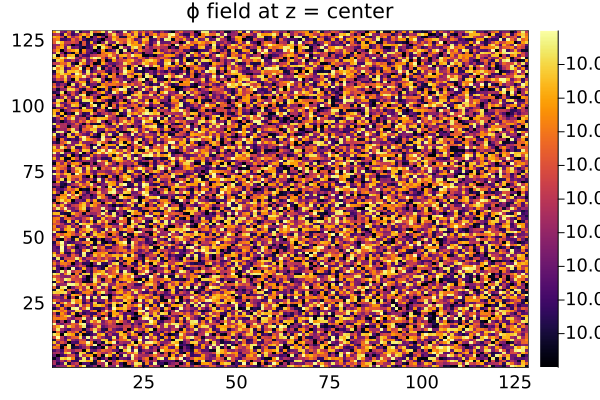

In [19]:
# 初期条件の可視化（中央断面の 2D ヒートマップ）
Plots.heatmap(field[1,:, :, div(Nl,2)], title="ϕ field at z = center", legend=true)

In [21]:
fieldList = reshape(field, 1, 2, Nl, Nl, Nl);

@time for i in 0:Int(Nf/dN)
    #i = 0;
    Nspan = (i*dN,(i+1)*dN);
    prob = ODEProblem(EoM!, fieldList[i+1,:,:,:,:], Nspan, (dx));
    sol = solve(prob,Tsit5(),reltol=1e-8,abstol=1e-8; save_everystep=false);
    fieldList = cat(fieldList, reshape(sol.u[end],1, 2, Nl, Nl, Nl); dims=1)
    #sol = nothing
end

2389.276543 seconds (64.78 G allocations: 3.091 TiB, 10.15% gc time)


In [157]:
Nspan = (0,Nf)
prob = ODEProblem(EoM!, field, Nspan, (dx));

@time sol = solve(prob,Tsit5(),reltol=1e-8,abstol=1e-8);

117.352537 seconds (3.59 G allocations: 181.564 GiB, 4.37% gc time)


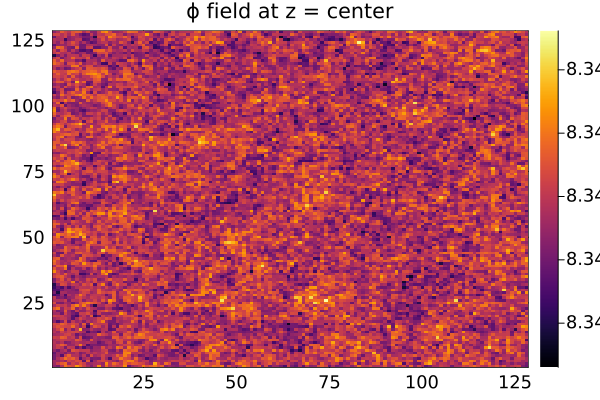

In [23]:
Plots.heatmap(#sol.u[end][1, :, :, div(Nl,2)]
    fieldList[end,1,:,:,div(Nl,2)], title="ϕ field at z = center", legend=true)

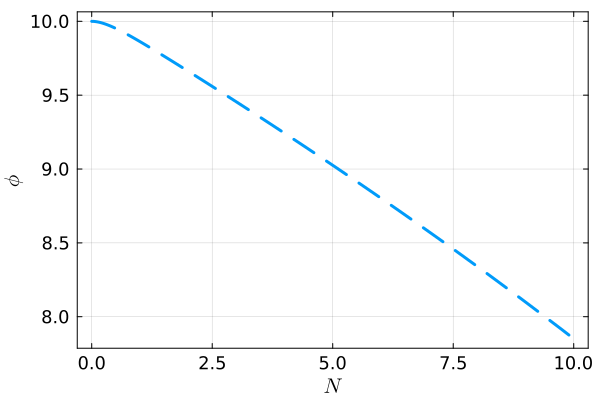

In [53]:
plot(sol.t, [sol.u[i][1,1,1,1] for i in 1:size(sol.u)[1]], xlabel=L"$N$", ylabel=L"$\phi$")

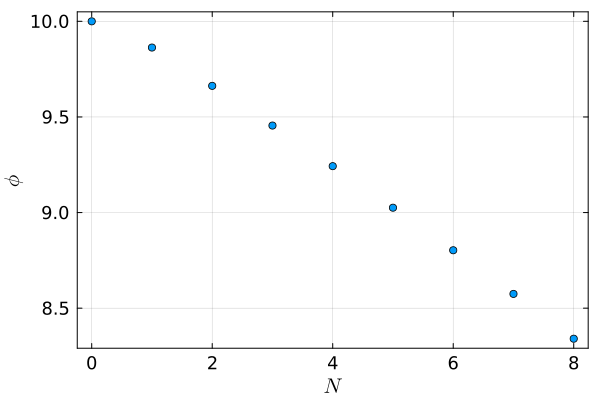

In [25]:
plot([i*dN for i=0:Int(Nf/dN)+1], fieldList[:,1,1,1,1], xlabel=L"$N$", ylabel=L"$\phi$", st=:scatter)